## Dial Tones
This is the most intersting lab sp far.
In this lab, we will have audio recordings for phones while typing the numbers to call.
We will use the DFT to analyse the spectra of the sound, and guess back the typed phone number.

The first step: it is all about isolating each tone from another; that could be detected by the sound amplitude being near to zero.
Once we have each time interval, we perform the DFT analysis to know more about the spectra of that time interval, and then try to guess the typed key on the keypad based on the fundamental frequency that is shown by the spectorgram.


Doing the inspection manually by the help of the numerical tools we have is going to be so easy.
The problem that is actually serious is how to turn this into an algorithm that can run on any application without a human there to do the inspection.


## Let's get started
DTMF signaling is the way analog phones used to send the dialed number over the line. It is still used in-call option selection. For example: "Press 4 to client service..."

|            | **1209 Hz** | **1336 Hz** | **1477 Hz** |
|------------|:-----------:|:-----------:|:-----------:|
| **697 Hz** |      1      |      2      |      3      |
| **770 Hz** |      4      |      5      |      6      |
| **852 Hz** |      7      |      8      |      9      |
| **941 Hz** |      *      |      0      |      #      |

There is something special about the frequencies chosen in the table.
They have been chosen in a way that they are "coprime".
In other words, no frequency is a multiple of another, and no two frequencies add up to the same frequency.
The above reduces the probability of detecting a wrong signal due to interference.
When a button is pressed, the two frequencies are generated simultaneously and sent over the line.
For instance, if the pressed button is '1', the the generated signal will be:
$$
x(t)=sin(2 \pi \cdot 697 \cdot t) + sin(2 \pi \cdot 1209 \cdot t)
$$

The official specifications for the DTMF standard are: 
 * each tone should be at least 65ms long
 * tones corresponding to successive digits should be separated by at least a silent gap of 65ms

In this notebook, we will build a DTMF decoder. Since the signal is going to be a discrete time signal, let's have the sampling frequency $F_s$
The generated signal will have the following expression:
$$
x[n]=sin(2 \pi \cdot \frac{f_1}{F_s} \cdot n) + sin( 2 \pi \cdot \frac{f_2}{F_s} \cdot n)
$$

The first thing to do is to write a DTMF encoder.

In [2]:
# Usual bookkeeping
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import IPython

In [3]:
plt.rcParams['figure.figsize'] = (14, 4)

In [4]:
# Let's consider a 24 kHz system 
Fs = 24000

In [5]:
def dtmf_dial(number):
    DTMF = {
        '1': (697, 1209), '2': (697, 1336), '3': (697, 1477),
        '4': (770, 1209), '5': (770, 1336), '6': (770, 1477),
        '7': (852, 1209), '8': (852, 1336), '9': (852, 1477),
        '*': (941, 1209), '0': (941, 1336), '#': (941, 1477),
    }
    MARK = 0.1
    SPACE = 0.1
    n = np.arange(0, int(Fs * MARK))
    x = np.array([])
    for digit in number:
        s = np.sin(2 * np.pi * (DTMF[digit][0] / Fs) * n) + np.sin(2 * np.pi * (DTMF[digit][1] / Fs) * n )
        x = np.concatenate((x, s, np.zeros(int (SPACE * Fs))))
    return x

In [6]:
# Now, let get the sampe corresponding to the following number
x = dtmf_dial('123##45')
IPython.display.Audio(x, rate=Fs)

The encoder is coded successfully
Now, it is the time to consider the decoder. We will have an audio file that we analyze and try to extract the fundamental frequencies, to guess finally the hiddne tone

We are going to adopt the following workflow:
* Split the signal into individual digit tones by looking at the positions of the gaps
* Perform the DFT for each digit tone
* Analysze the peaks and recover the composed digit

We will assume that the full signal is in memory and perform a one-time analysis instead of batch processing.
Batch processing is something like a real-time processing and, indeed, that is going to be the subject of another notebook.

To split the signal, the idea is to look at the local energy over small windows, when the signal is silence, we simply cut it.
Let's see how we can do that.
Let's first preview the tone that we have generated.

<StemContainer object of 3 artists>

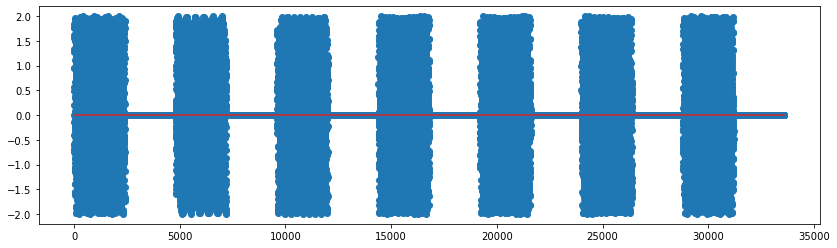

In [7]:
plt.stem(x)

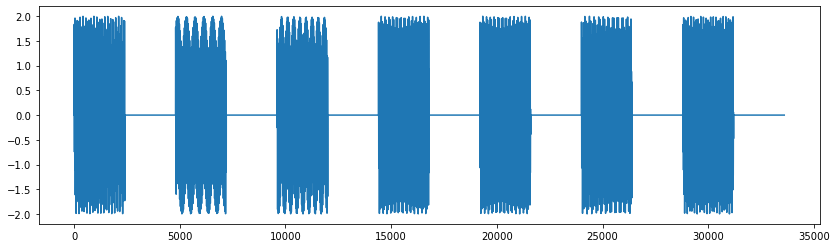

In [8]:
plt.plot(x)

Se should find the high and low-energy sections of the signal. Let's suppose that we are using an analysis window of 240 samples.
It corresponds to 10ms in our $F_s$
We can easily find the local energy like so:

<StemContainer object of 3 artists>

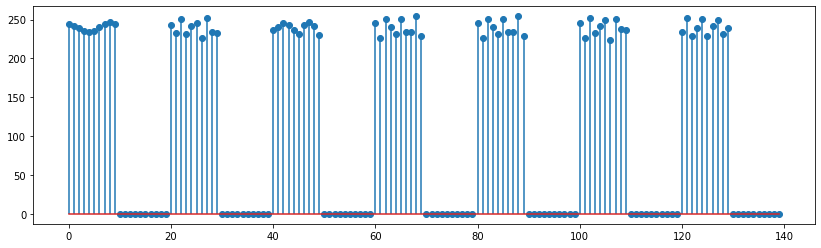

In [9]:
w = np.reshape(x[:int(len(x) / 240) * 240], (-1, 240))
we = np.sum(w * w, axis=1)
plt.stem(we)

From the plot, it appears clearly that set a threshold of about 200 to separate tone sections from silence sections.
Let's write a function that returns a start and stop sections of the tone in an input signal.

Now that we have the tone intervals, let's run a DFT over each interval and find the main frequencies in that interval:

In [35]:
def dtmf_split(x, win=240, th=200):
    def enough_energy(e):
        return e >= th
    
    edges = []
    
    w = np.reshape(x[:int(len(x) / win) * win], (-1, win))
    we = np.sum(w * w, axis=1)
    L = len(w)
    
    start  = 0
    while start < L:
        if not enough_energy(we[start]):
            start = start + 1
            continue
        end = start
        while end < L:
            if enough_energy(we[end]):
                end = end + 1
            else:
                break
        if start != end:
            edges.append((start * win, end * win))
        start = end + 1
    return edges
    

In [11]:
edges = dtmf_split(x)
print(edges)

[(0, 2400), (4800, 7200), (9600, 12000), (14400, 16800), (19200, 21600), (24000, 26400), (28800, 31200)]


It looks good now that we have a splitter.
Let's run the DFT over each section and find the fundamental frequences from which we will predict the tone according to the frequency.
One thing is needed before, which is to convert the discrete frequencies that we have into real-world frequencies using the formula we put that day.

Let's consider the first interval

<StemContainer object of 3 artists>

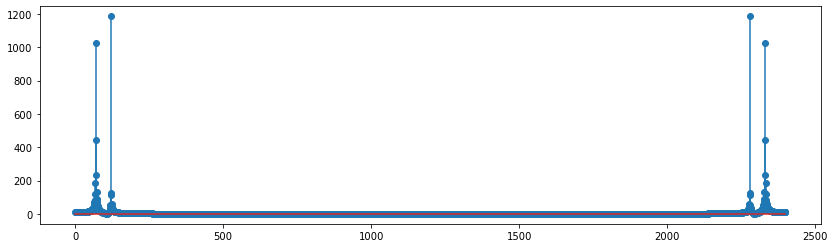

In [12]:
x0 = x[edges[0][0]:edges[0][1]]
X0 = np.fft.fft(x0)
plt.stem(abs(X0))


In [17]:
KEYS = [
    ['1','2','3'],
    ['4','5','6'],
    ['7','8','9'],
    ['*','0','#'],
]

In [13]:
LO_RANGE = (680.0, 960.0)
HI_RANGE = (1180.0, 1500.0)

In [14]:
LO_FREQS = np.array([697.0, 770.0, 852.0, 941.0])
HI_FREQS = np.array([1209.0, 1336.0, 1477.0])

In [18]:
def dtmf_decode(x, edges=None):
    if edges == None:
        edges = dtmf_split(x)
    
    number = []
    for edge in edges:
        X = abs(np.fft.fft(x[edge[0]:edge[1]]))
        N = len(X)
        res = float(Fs) / N
        
        low_start_index = int(LO_RANGE[0] / res)
        low_end_index = int(LO_RANGE[1] / res)
        
        high_start_index = int(HI_RANGE[0] / res)
        high_end_index = int(HI_RANGE[1] / res)
        
        low_peak_index = low_start_index + np.argmax(X[low_start_index:low_end_index])
        high_peak_index = high_start_index + np.argmax(X[high_start_index:high_end_index])
        
        high_peak_freq = high_peak_index * res
        low_peak_freq = low_peak_index * res
        
        col = np.argmin(abs(high_peak_freq - HI_FREQS))
        row = np.argmin(abs(low_peak_freq - LO_FREQS))
        number.append(KEYS[row][col])
    return number
    

In [30]:
print(dtmf_decode(x))


['1', '2', '3', '#', '#', '4', '5']


In [33]:
def dtmf_decod(x, edges = None):
    # the DTMF frequencies
    LO_FREQS = np.array([697.0, 770.0, 852.0, 941.0])
    HI_FREQS = np.array([1209.0, 1336.0, 1477.0])

    KEYS = [['1', '2', '3'], ['4', '5', '6'], ['7', '8', '9'], ['*', '0', '#']]
    
    # frequency ranges to search for low and high DTMF tones
    LO_RANGE = (680.0, 960.0)
    HI_RANGE = (1180.0, 1500.0)

    number = []
    
    # now examine each tone in turn. the freqency mapping on the DFT
    #  axis will be dependent on the length of the data vector
    if edges is None:
        edges = dtmf_split(x)
    for g in edges:
        # compute the DFT of the tone segment
        X = abs(np.fft.fft(x[g[0]:g[1]]))
        N = len(X)
        # compute the resolution in Hz of a DFT bin
        res = float(Fs) / N
        
        # find the peak location within the low freq range
        a = int(LO_RANGE[0] / res)
        b = int(LO_RANGE[1] / res)
        lo = a + np.argmax(X[a:b])
        # find the peak location within the high freq range
        a = int(HI_RANGE[0] / res)
        b = int(HI_RANGE[1] / res)
        hi = a + np.argmax(X[a:b])
      
        # now match the results to the DTMF frequencies
        row = np.argmin(abs(LO_FREQS - lo * res))
        col = np.argmin(abs(HI_FREQS - hi * res))

        # and finally convert that to the pressed key
        number.append(KEYS[row][col])
    return number

The work is done, we can take an audio file, and guess back the typed numbers.
The next thing is to introduce some noise, and test the performance of our algorithm

In [53]:
x_noisy = x + np.random.uniform(-2, 2, len(x))
print(dtmf_decode(x_noisy))

['3']


The result we got here is different from the original number we typed, something should be changed so that the noise is handled

As a first intuition, the noise adds some enerfy to our signal, let's consider rising the threshold energy and decode the signal, the result is below:

In [63]:
print(dtmf_decode(x_noisy, dtmf_split(x_noisy, th=400)))
print(dtmf_decode(x_noisy, dtmf_split(x_noisy, th=350)))
print(dtmf_decode(x_noisy, dtmf_split(x_noisy, th=500)))

['1', '2', '3', '#', '#', '4', '5']
['1', '2', '2', '3', '#', '#', '4', '5']
['1', '1', '2', '3', '3', '#', '#', '4', '5']


The static threshold that we put before is no longer working, we are needing a more sophisticated way to do define the threshold enery and do the splitting in general.

Another problem appears, if we consider more practical details like noise for example, the alogirithm is not going to perform well.
Let's try the following

Even with the non-noisy signal, if the change the threshold energy, we would end up with wrong result.
As noted before, there should be another way to be discovered later, which is much more efficient in real-world situations.

In [38]:
dtmf_decod(x, dtmf_split(x, th=250))

['2', '2', '5', '5', '5', '5', '5', '5', '4', '4', '5', '5']